In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import cv2
from skimage import io,filters

In [2]:
PATH= '../Base de datos/BD 810/'

Segmentación de la hoja

In [3]:
def retinex_correction(image, sigma=50):
    # Aplicar la corrección de brillo
    #imagen_ajustada = correccion_brillo_adaptativo(image)
    # Convertir la imagen al espacio de color logarítmico
    log_image = np.log1p(image.astype(np.float32))

    # Calcular el tamaño del kernel para el filtro Gaussiano
    ksize = (sigma * 6 + 1, sigma * 6 + 1)
    ksize = (ksize[0] // 2 * 2 + 1, ksize[1] // 2 * 2 + 1)  # Asegurar un tamaño impar

    # Aplicar el filtro Gaussiano en la imagen logarítmica
    blur_image = cv2.GaussianBlur(log_image, ksize, 0)

    # Calcular la diferencia entre la imagen logarítmica original y la filtrada
    diff_image = log_image - blur_image

    # Obtener la imagen corregida sumando la diferencia a la imagen original
    corrected_image = np.clip(image + diff_image, 0, 255).astype(np.uint8)

    return corrected_image

def preprocess_image(image):
    # Aplicar la corrección de iluminación Retinex
    corrected_image = retinex_correction(image)

    # Convertir la imagen corregida al espacio de color HSV
    hsv = cv2.cvtColor(corrected_image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color de la hoja en HSV
    lower_green = np.array([30, 30, 30])
    upper_green = np.array([100, 255, 255])  # Ajustar los valores para incluir más tonos de verde
    # Definir el rango de color adicional en HSV para detectar el tono de verde específico
    #lower_green_additional = np.array([99, 0, 63])
    #upper_green_additional = np.array([119, 19, 73])
    lower_green_additional = np.array([25, 0, 0])
    upper_green_additional = np.array([40, 255, 255])
    # Definir el rango de color adicional en HSV para detectar el tono de verde específico
    lower_green_additional_2 = np.array([50, 0, 0])
    upper_green_additional_2 = np.array([70, 255, 255])

    # Crear una máscara para la zona verde
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Aplicar la máscara adicional de zona verde más birllante
    mask_additional = cv2.inRange(hsv, lower_green_additional, upper_green_additional)

    # Aplicar la máscara adicional 2 al espacio de color HSV
    mask_additional_2 = cv2.inRange(hsv, lower_green_additional_2, upper_green_additional_2)

      # Combinar las máscaras actual y adicional
    mask_combined = cv2.bitwise_or(green_mask, mask_additional)

    # Combinar las máscaras actual, adicional y adicional 2
    mask_combined = cv2.bitwise_or(mask_combined, mask_additional_2)

    # Aplicar operaciones morfológicas para eliminar el ruido y mejorar los bordes
    kernel = np.ones((5, 5), np.uint8)
    green_mask = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=2)
    green_mask = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Aplicar detección de contornos y eliminar los contornos pequeños
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 1000  # Área mínima del contorno para considerar como zona verde
    for contour in contours:
        if cv2.contourArea(contour) < min_contour_area:
            cv2.drawContours(green_mask, [contour], -1, 0, thickness=cv2.FILLED)

    # Aplicar las máscaras a la imagen original
    green_segmented = cv2.bitwise_and(image, image, mask=green_mask)

    # Retornar la imagen segmentada de la zona verde
    return green_segmented

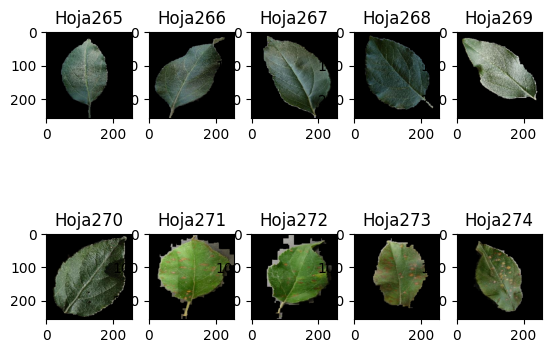

In [4]:
x=0
for i in range (265,275,1): #581 y 584
    x=x+1
    org_image = cv2.imread(PATH + str(i) + ".jpg", cv2.IMREAD_COLOR)
    green_segmented = preprocess_image(org_image)
    filtered_image = preprocess_image(org_image)
    plt.subplot(2,5,x)
    plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
    plt.title('Hoja'+str(i))
plt.show()
    

Máscara para Rust

In [5]:
import cv2
import numpy as np

def segment_disease_rust(green_segmented):
    # Convertir la imagen segmentada de verde a HSV
    hsv_image = cv2.cvtColor(green_segmented, cv2.COLOR_BGR2HSV)

    lower_range = np.array([0, 50, 50])
    upper_range = np.array([30, 255, 255])

    # Crear una máscara para los píxeles dentro del rango
    mask = cv2.inRange(hsv_image, lower_range, upper_range)

    # Aplicar la máscara combinada a la imagen segmentada de verde
    disease_segmented = cv2.bitwise_and(green_segmented, green_segmented, mask=mask)

    return disease_segmented

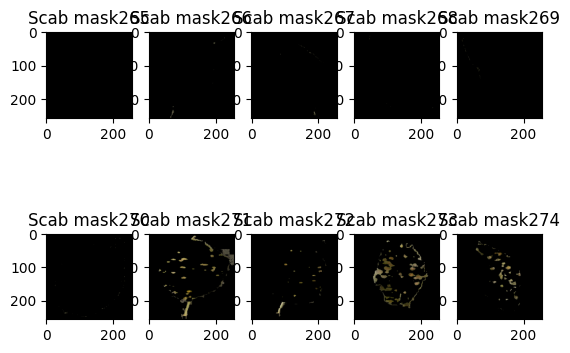

In [6]:
x=0
for i in range (265,275,1): #581 y 584
    x=x+1
    org_image = cv2.imread(PATH + str(i) + ".jpg", cv2.IMREAD_COLOR)
    green_segmented = preprocess_image(org_image)
    disease_segmented_scab= segment_disease_rust(green_segmented)
    plt.subplot(2,5,x)
    plt.imshow(cv2.cvtColor(disease_segmented_scab, cv2.COLOR_BGR2RGB))
    plt.title('Scab mask'+str(i))
plt.show()

Máscara para Scab

In [7]:
def resaltar_partes_oscuras(image):
    # Convierte la imagen a escala de grises
    gray_image = cv2.cvtColor(preprocess_image(image), cv2.COLOR_BGR2GRAY) ##Preprocess_image es la imagen de la hoja verde

    # Aplica la ecualización de histograma adaptativo a la imagen en escala de grises
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(gray_image)

    # Fusiona la imagen en escala de grises ecualizada con la imagen original en color
    enhanced_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)

    return enhanced_image

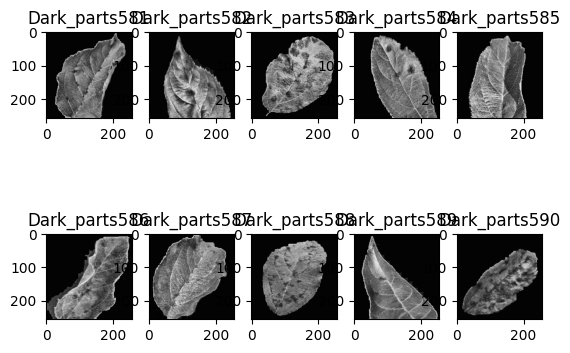

In [8]:
x=0
for i in range (581,591,1):
    x=x+1
    org_images = cv2.imread(PATH + str(i) + ".jpg", cv2.IMREAD_COLOR) 
    dark_parts= resaltar_partes_oscuras(org_images)
    plt.subplot(2,5,x)
    plt.imshow(cv2.cvtColor(dark_parts, cv2.COLOR_BGR2RGB))
    plt.title('Dark_parts'+str(i))
plt.show()

In [9]:
def aplicar_umbralizacion_otsu(image):
    # Convierte la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplica la umbralización automática con el método de Otsu
    _, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return threshold_image

def custom_xor(filtered_image, threshold_image, opt):
    output_image = filtered_image.copy()
# Ensure both images have the same dimensions
    threshold_image = cv2.resize(threshold_image, (filtered_image.shape[1], filtered_image.shape[0]))

# Iterate through each pixel in the mask image
    for y in range(filtered_image.shape[0]):
        for x in range(filtered_image.shape[1]):
        # Check if the pixel is black or below a certain threshold
            if threshold_image[y, x].all() == 0:
            # Apply the correspo
                if opt == 1:
                    output_image[y, x] = [0, 0, 0]  # Set it to black (or any desired value)
                else:
                    output_image[y, x] = 0
        
    return output_image

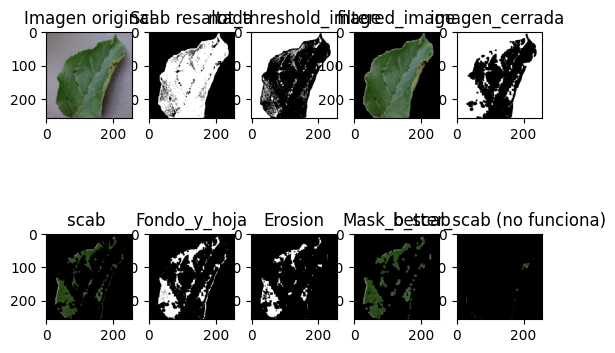

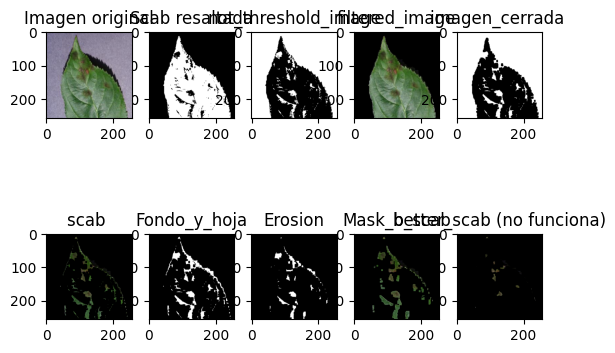

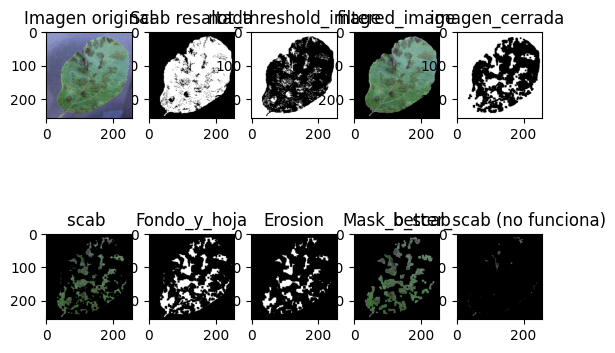

In [18]:
kernel = np.ones((5, 5), np.uint8)
kernel_erosion = np.ones((3, 3), np.uint8)
for i in range (581,584,1): #581 y 584
    org_image = cv2.imread(PATH + str(i) + ".jpg", cv2.IMREAD_COLOR)
    filtered_image = preprocess_image(org_image)
    dark_parts= resaltar_partes_oscuras(org_image)
    threshold_image= aplicar_umbralizacion_otsu(dark_parts)
    plt.subplot(252)
    plt.imshow(cv2.cvtColor(threshold_image, cv2.COLOR_BGR2RGB))
    plt.title('Scab resaltada')
    plt.subplot(251)
    plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen original')
    
    not_threshold_image =  cv2.bitwise_not(threshold_image)
    plt.subplot(253)
    plt.imshow(cv2.cvtColor(not_threshold_image, cv2.COLOR_BGR2RGB))
    plt.title('not_threshold_image')
    
    plt.subplot(254)
    plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
    plt.title('filtered_image')
    
    # Aplicar la operación de cierre morfológico
    imagen_cerrada = cv2.morphologyEx(not_threshold_image, cv2.MORPH_CLOSE, kernel)
    plt.subplot(255)
    plt.imshow(cv2.cvtColor(imagen_cerrada, cv2.COLOR_BGR2RGB))
    plt.title('imagen_cerrada ')
    
    scab = custom_xor(filtered_image, imagen_cerrada, 1)
    plt.subplot(256)
    plt.imshow(cv2.cvtColor(scab, cv2.COLOR_BGR2RGB))
    plt.title('scab ')

    fondo_y_hoja = custom_xor(imagen_cerrada, filtered_image, 0)
    plt.subplot(257)
    plt.imshow(cv2.cvtColor(fondo_y_hoja, cv2.COLOR_BGR2RGB))
    plt.title('Fondo_y_hoja')

    Erosion = cv2.erode(fondo_y_hoja, kernel_erosion, iterations=1)
    plt.subplot(258)
    plt.imshow(cv2.cvtColor(Erosion, cv2.COLOR_BGR2RGB))
    plt.title('Erosion')

    plt.subplot(259)
    better_scab = cv2.bitwise_and(filtered_image, filtered_image, mask=Erosion)
    imagen_dilatada = cv2.dilate(Erosion, kernel, iterations=1)
    better_scab = cv2.bitwise_and(filtered_image, filtered_image, mask=imagen_dilatada)
    plt.imshow(cv2.cvtColor(better_scab, cv2.COLOR_BGR2RGB))
    plt.title('Mask_b_scab')

    plt.subplot(2,5,10)
    hsv_image = cv2.cvtColor(better_scab, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 0, 0])
    upper_green = np.array([85, 255, 255])
    # Crear una máscara para los píxeles verdes
    mask = cv2.inRange(hsv_image, lower_green, upper_green)
    # Aplicar la máscara a la imagen original
    imagen_sin_verde = cv2.bitwise_and(better_scab, better_scab, mask=~mask)
    #filter_scab = aplicar_umbralizacion_otsu(better_scab)
    plt.imshow(cv2.cvtColor(imagen_sin_verde, cv2.COLOR_BGR2RGB))
    plt.title('better_scab (no funciona)')
    plt.show()